In [1]:
%matplotlib inline
import os
os.environ['PY3_PROD'] = '1'
%load_ext autoreload
%autoreload 2
os.system('kinit')

1

In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
from pycmqlib3.utility import dbaccess, dataseries, misc
from pycmqlib3.analytics.tstool import *
from pycmqlib3.analytics.btmetrics import *
from pycmqlib3.analytics.backtest_utils import *
from pycmqlib3.strategy.signal_repo import *

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
matplotlib.rcParams['figure.figsize'] = (12, 8)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

# define product groups and start times

In [4]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'SM', "SF", 'nr', 'SA', 'UR'] # 'ZC', 
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn', 'ss']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc', 'fu', 'eg', 'eb', 'lu', 'pg', 'PF'] 
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs', 'b'] #, 'b']
ags_soft_mkts = ['CF', 'SR', 'jd', 'AP', 'sp', 'CJ', 'lh', 'PK', 'CY'] # 'CY',] 

ags_all_mkts = ags_oil_mkts + ags_soft_mkts

eq_fut_mkts = ['IF', 'IH', 'IC']
bond_fut_mkts = ['T', 'TF', 'TS']

fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts

daily_start_dict = { 'c': datetime.date(2011,1,1), 'm': datetime.date(2011,1,1),
    'y': datetime.date(2011,1,1), 'l': datetime.date(2011,1,1), 'rb':datetime.date(2011,1,1),
    'p': datetime.date(2011,1,1), 'cu':datetime.date(2011,1,1), 'al':datetime.date(2011,1,1),
    'zn':datetime.date(2011,1,1), 'au':datetime.date(2015,12,1), 'v': datetime.date(2011,1,1),
    'a': datetime.date(2011,1,1), 'ru':datetime.date(2011,1,1), 'ag':datetime.date(2012,6,1),
    'i': datetime.date(2014,1,1), 'j': datetime.date(2012,6,1), 'jm':datetime.date(2013,7,1),
    'CF':datetime.date(2012,5,1),  'TA':datetime.date(2012,4,15),
    'PM':datetime.date(2013,10,1), 'RM':datetime.date(2013,1,1),  'SR':datetime.date(2013,1,1),
    'FG':datetime.date(2013,1,1),  'OI':datetime.date(2013,5,1),  'RI':datetime.date(2013,1,1),
    'WH':datetime.date(2014,5,1),  'pp':datetime.date(2014,5,1),
    'IF':datetime.date(2010,5,1),  'MA':datetime.date(2012,1,1),  'TF':datetime.date(2019,6,1),
    'IH':datetime.date(2015,5,1),  'IC':datetime.date(2015,5,1),  'cs':datetime.date(2015,2,1),
    'jd':datetime.date(2014,5,1),  'ni':datetime.date(2015,9,1),  'sn':datetime.date(2017,5,1),
    'ZC':datetime.date(2013,11,1), 'hc':datetime.date(2016, 4, 1), 'SM': datetime.date(2017,1,1),
    'SF': datetime.date(2017,9,1), 'CY': datetime.date(2017, 9, 1), 'AP': datetime.date(2018, 1, 1),
    'TS': datetime.date(2018, 9, 1), 'fu': datetime.date(2018, 9, 1), 'sc': datetime.date(2018, 10, 1),
    'b': datetime.date(2018, 1, 1), 'pb': datetime.date(2016, 7, 1), 'bu': datetime.date(2015,9,15),
    'T':datetime.date(2019,4,1), 'ss': datetime.date(2020, 5, 1), 'sp': datetime.date(2019, 5, 1),
    'CJ': datetime.date(2019, 8, 9), 'UR': datetime.date(2019, 8, 9), 'SA': datetime.date(2020, 1, 1),
    'eb': datetime.date(2020, 2, 1), 'eg': datetime.date(2019, 4, 2), 'rr': datetime.date(2019, 9, 1),
    'pg': datetime.date(2020, 9, 5), 'lu': datetime.date(2020, 10, 1), 'nr': datetime.date(2020,1,1),
    'lh': datetime.date(2021,5,1), 'PF': datetime.date(2021,1,1), 'PK': datetime.date(2021,4,1), }

# load historical data

In [5]:
fields = ['contract', 'open', 'high', 'low', 'close', 'volume', 'openInterest', 'diff_oi', 'expiry', 'mth', 'shift']

start_date = datetime.date(2010,1,1)
end_date = datetime.date(2023,7,24)
shift_mode = 2
roll_name = 'hot'
roll_file_loc = "C:/dev/wtdev/config/"
sim_markets = all_markets
nb_cont = 2
freq='d1'

data_df = pd.DataFrame()

for prodcode in sim_markets:
    for nb in range(nb_cont):
        xdf = dataseries.nearby(prodcode,
                                nb+1,
                                start_date=start_date, 
                                end_date = end_date, 
                                shift_mode = shift_mode,
                                freq=freq, 
                                roll_name=roll_name, 
                                config_loc=roll_file_loc)
        xdf['expiry'] = xdf['contract'].map(misc.contract_expiry)
        xdf['contmth'] = xdf['contract'].map(misc.inst2contmth)
        xdf['mth'] = xdf['contmth'].apply(lambda x: x//100 * 12 + x % 100) 
        xdf['product'] = prodcode
        xdf['code'] = f'c{nb+1}'
        data_df = data_df.append(xdf)

df = pd.pivot_table(data_df.reset_index(), index='date', columns = ['product', 'code'], values = list(fields), aggfunc = 'last')
df = df.reorder_levels([1, 2, 0], axis=1).sort_index(axis=1)
df.columns.rename(['product', 'code', 'field',], inplace = True)
df.index = pd.to_datetime(df.index)

cdates = pd.date_range(start=start_date, end=end_date, freq='D')
bdates = pd.bdate_range(start=start_date, end=end_date, freq='C', holidays=misc.CHN_Holidays)
df.tail(5)

product         AP                                                         \
code            c1                                                          
field        close contract  diff_oi      expiry    high     low      mth   
date                                                                        
2023-07-18  8647.0   AP2310 -17209.0  2023-10-20  8700.0  8624.0  24286.0   
2023-07-19  8648.0   AP2310  -1747.0  2023-10-20  8685.0  8605.0  24286.0   
2023-07-20  8687.0   AP2310   8100.0  2023-10-20  8714.0  8635.0  24286.0   
2023-07-21  8590.0   AP2310  -6405.0  2023-10-20  8700.0  8565.0  24286.0   
2023-07-24  8682.0   AP2310  -1725.0  2023-10-20  8699.0  8578.0  24286.0   

product                                                                   \
code                                                 c2                    
field         open openInterest shift    volume   close contract diff_oi   
date                                                                       
2023-07-18  8666.0     147958.0   0.0   73663.0  8576.0   AP2401  -542.0   
2023-07-19  8645.0     146211.0   0.0   62082.0  8581.0   AP2401   -76.0   
2023-07-20  8645.0     154311.0   0.0   84932.0  8601.0   AP2401   294.0   
2023-07-21  8700.0     147906.0   0.0  111925.0  8535.0   AP2401  -230.0   
2023-07-24  8580.0     146181.0   0.0  102253.0  8591.0   AP2401   149.0   

product                                                                     \
code                                                                         
field           expiry    high     low      mth    open openInterest shift   
date                                                                         
2023-07-18  2024-01-12  8621.0  8550.0  24289.0  8621.0      21224.0   0.0   
2023-07-19  2024-01-12  8608.0  8541.0  24289.0  8580.0      21148.0   0.0   
2023-07-20  2024-01-12  8616.0  8570.0  24289.0  8570.0      21442.0   0.0   
2023-07-21  2024-01-12  8605.0  8509.0  24289.0  8600.0      21212.0   0.0   
2023-07-24  2024-01-12  8608.0  8520.0  24289.0  8520.0      21361.0   0.0   

product                  CF                                                  \
code                     c1                                                   
field       volume    close contract  diff_oi      expiry     high      low   
date                                                                          
2023-07-18  2898.0  17180.0   CF2309  -5576.0  2023-09-14  17285.0  16910.0   
2023-07-19  2053.0  17160.0   CF2309 -15013.0  2023-09-14  17190.0  16830.0   
2023-07-20  2591.0  17145.0   CF2309 -12898.0  2023-09-14  17300.0  17105.0   
2023-07-21  3819.0  17165.0   CF2309 -37421.0  2023-09-14  17360.0  17085.0   
2023-07-24  3537.0  16925.0   CF2309 -25428.0  2023-09-14  17075.0  16860.0   

product                                                                      \
code                                                            c2            
field           mth     open openInterest shift    volume    close contract   
date                                                                          
2023-07-18  24285.0  16950.0     443056.0   0.0  342548.0  17145.0   CF2401   
2023-07-19  24285.0  16995.0     428041.0   0.0  521249.0  17205.0   CF2401   
2023-07-20  24285.0  17195.0     415172.0   0.0  311723.0  17195.0   CF2401   
2023-07-21  24285.0  17145.0     377752.0   0.0  318998.0  17300.0   CF2401   
2023-07-24  24285.0  16990.0     352249.0   0.0  238096.0  17055.0   CF2401   

product                                                              \
code                                                                  
field       diff_oi      expiry     high      low      mth     open   
date                                                                  
2023-07-18   9651.0  2024-01-12  17230.0  16870.0  24289.0  16900.0   
2023-07-19  26299.0  2024-01-12  17225.0  16835.0  24289.0  16950.0   
2023-07-20  23427.0  2024-01-12  17345.0  17125.0  24289.0  17230.0 

In [6]:
asset_pairs = [('i', 'rb'), ('i', 'hc'), ('i', 'j'), ('j', 'jm'),]
beta_ret_dict = {}
betas_dict = {}
for trade_asset, index_asset in asset_pairs:
    asset_df = df[[(index_asset, 'c1', 'close'), (trade_asset, 'c1', 'close')]].copy(deep=True).droplevel([1,2], axis=1)
    asset_df = asset_df.dropna(subset=[trade_asset]).ffill()

    for asset in asset_df:
        asset_df[f'{asset}_pct'] = asset_df[asset].pct_change().rolling(5).mean()
    asset_df['beta'] = asset_df[f'{index_asset}_pct'].rolling(244).cov(asset_df[f'{trade_asset}_pct'])/asset_df[f'{index_asset}_pct'].rolling(244).var()
    key = '_'.join([trade_asset, index_asset])
    asset_df[key] = asset_df[trade_asset].pct_change() - asset_df['beta'] * asset_df[index_asset].pct_change().fillna(0)
    beta_ret_dict[key] = asset_df[key].dropna()
    betas_dict[key] = asset_df['beta']


# funda data loading/processing

In [7]:
from pycmqlib3.utility.spot_idx_map import index_map

data_df = dbaccess.load_codes_from_edb(index_map.keys(), source='ifind', column_name='index_code')
data_df = data_df.rename(columns=index_map)
data_df

index_code,rebar_gz,rebar_sh,rebar_sy,hrc_bj,hrc_gz,hrc_sh,crc_bj,crc_gz,crc_sh,crc_shenyang,gi_0.5_sh,gi_1.0_sh,billet_js,billet_ts,scrap_zjg,scrap_ts,coal_5500_qhd,hrc_tj,coal_5500_sx_qhd,pbf_cfd,highwire_6.5,plate_8mm,gi_0.5,channel_16,ibeam_25,angle_50x5,hsec_200x100,hsec_300x300,hsec_400x200,strip_2.5x355,strip_3.0x685,seemless_pipe_108x4.5,pipe_1.5x3.25,pipe_4x3.75,scrap_sh,femn65si17_neimeng,femn65si17_guangxi,femn65si17_tj,pci_jincheng,pci_yangquan,cu_lme_3m_15m_spd,cu_lme_3m_27m_spd,al_lme_3m_15m_spd,al_lme_3m_27m_spd,ni_lme_3m_15m_spd,ni_lme_3m_27m_spd,sn_lme_3m_15m_spd,zn_lme_3m_15m_spd,zn_lme_3m_27m_spd,pb_lme_3m_15m_spd,...,io_inv_imp_mill(64),io_inv_dom_mill(64),io_inv_imp_mill_0_200,io_inv_mill_200_300,io_inv_mill_300_400,io_inv_mill_400,cu_lme_0m_3m_spd,sn_lme_0m_3m_spd,pb_lme_0m_3m_spd,zn_lme_0m_3m_spd,al_lme_0m_3m_spd,ni_lme_0m_3m_spd,fbf_qd,ssf_qd,royhill_rz,coke_tj,rebar_inv_mill,wirerod_inv_mill,hrc_inv_mill,crc_inv_mill,plate_inv_mill,coal_5500_jingtang,cu_mine_tc,jmb_qd,wirerod_inv_social,hrc_inv_social,plate_inv_social,crc_inv_social,hrc_inv_all,rebar_inv_all,wirerod_inv_all,plate_inv_all,crc_inv_all,rebar_inv_social,io_inv_31ports,io_inv_41ports,io_inv_45ports,io_inv_31ports_trade,io_removal_31ports,io_removal_41ports,io_removal_45ports,coke_ts_xb,coke_changzhi_xb,coke_sh_xb,coke_xuzhou_xb,consteel_daily_sales,SM_inv_mill,SF_inv_mill,steel_inv_social,long_inv_social
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1992-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40412.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40412.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-09-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40412.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-06-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240.00,410.00,39.00,79.5,1595.0,2785.0,1010.0,-10.00,8.50,112.00,...,NaN,NaN,NaN,NaN,NaN,NaN,33.75,235.0,37.00,-18.75,-9.05,113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-06-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,250.00,420.00,49.00,74.5,1655.0,2860.0,910.0,-13.25,-2.25,110.00,...,NaN,NaN,NaN,NaN,NaN,NaN,47.50,275.0,39.00,-18.50,-7.75,140.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [8]:
spot_df = data_df.dropna(how='all').copy(deep=True)

spot_df['steel_inv_mill'] = spot_df['rebar_inv_mill'] + spot_df['wirerod_inv_mill'] + spot_df['hrc_inv_mill'] + spot_df['crc_inv_mill'] + spot_df['plate_inv_mill']
spot_df['steel_major5_inv'] = spot_df['steel_inv_social'] + spot_df['steel_inv_mill'] 
# spot_df['hrc_io'] = spot_df['billet_js']/spot_df['fbf_qd']
# spot_df['hrc_pci'] = spot_df['billet_js']/spot_df['pci_jincheng']
# spot_df['hrc_coke'] = spot_df['hrc_tj']/spot_df['coke_changzhi']
# spot_df['hrc_scrap'] = spot_df['hrc_tj']/spot_df['scrap_zjg']
# spot_df['strip_hsec2'] = spot_df['strip_3.0x685'] - spot_df['hsec_200x100']
# spot_df['crc_hrc'] = spot_df['crc_sh'] - spot_df['hrc_sh']
# spot_df['pipe_strip'] = spot_df['pipe_1.5x3.25'] - spot_df['strip_3.0x685']

spot_df['margin_hrc_pbf'] = spot_df['hrc_sh'] - 1.7*spot_df['pbf_cfd']-0.45*spot_df['coke_xuzhou_xb']
spot_df['margin_hrc_macf'] = spot_df['hrc_sh'] - 1.7*spot_df['macf_cfd']-0.45*spot_df['coke_xuzhou_xb']
#spot_df['hc_margin_jmb'] = spot_df['hrc_sh'] - 1.7*spot_df['jmb_qd']-0.45*spot_df['coke_xuzhou_xb']
spot_df['strip_hsec'] = spot_df['strip_3.0x685'] - spot_df['hsec_400x200']
spot_df['flat_hsec'] = (spot_df['plate_8mm'] + spot_df['hrc_sh'] + spot_df['crc_sh'] + spot_df['strip_3.0x685'])/4 - spot_df['hsec_400x200']
spot_df['io_inv_mill(64)'] = spot_df['io_inv_imp_mill(64)'] + spot_df['io_inv_dom_mill(64)']


In [9]:
spot_df = spot_df.reindex(index=cdates)
for col in [
    'io_inv_imp_mill(64)', 
    'io_inv_dom_mill(64)',
]:
    spot_df[col] = spot_df[col].shift(1)
    
for col in [
    'rebar_inv_social',
    'wirerod_inv_social',
    'long_inv_social',
    'hrc_inv_social',
    'crc_inv_social',
    'plate_inv_social',
    'steel_inv_social',
    'rebar_inv_mill',
    'wirerod_inv_mill',
    'hrc_inv_mill',
    'crc_inv_mill',
    'plate_inv_mill',    
]:
    spot_df[col] = spot_df[col].shift(-1)


# feature study

In [10]:
vol_win=20
pnl_tenors = ['6m', '1y', '2y', '3y', '4y', '5y', '6y', '7y', '8y', '9y']

empiric_assets = ['cu', 'zn', 'ni', 'al', 'pb', 'sn']

vol_df = get_asset_vols(df, empiric_assets, vol_win=vol_win, vol_type='pct_chg')
df_pxchg = df.loc[:, df.columns.get_level_values(0).isin(empiric_assets) 
                   & (df.columns.get_level_values(1)=='c1') 
                   & (df.columns.get_level_values(2)=='close')
                  ].droplevel([1, 2], axis=1).dropna(how='all').pct_change()

# ## for beta neutral
# empiric_assets = ['i_rb', 'i_hc', 'j_jm']
# df_pxchg = pd.DataFrame(index=beta_ret_dict[empiric_assets[0]].index, columns=empiric_assets)
# vol_df = pd.DataFrame(index=beta_ret_dict[empiric_assets[0]].index, columns=empiric_assets)
# for asset in empiric_assets:
#     df_pxchg[asset] = beta_ret_dict[asset].dropna()
#     vol_df[asset] = df_pxchg[asset].rolling(vol_win).std()

customerized signal

sharpe       1.406276
sharpe_6m    1.209457
sharpe_1y    1.332679
sharpe_2y    1.317984
sharpe_3y    1.391181
sharpe_4y    1.369705
sharpe_5y    1.354981
sharpe_6y    1.410693
sharpe_7y    1.393616
sharpe_8y    1.492533
sharpe_9y    1.630221
Name: total, dtype: float64
product          cu        zn        ni        al        pb        sn
sharpe     0.986369  0.449334  0.877105  0.292314  1.070812  0.783709
sharpe_6m  1.242100  1.598403 -0.478507  0.332743  0.989372 -0.128643
sharpe_1y  0.292170  0.874790  1.003410  0.135578  1.377573  0.195501
sharpe_2y  0.338872  1.006831  0.869525  0.201296  1.013410  0.221738
sharpe_3y  0.896667  0.884286  0.850399  0.276381  0.659376  0.404908
sharpe_4y  0.990452  0.678758  0.798067  0.000480  0.770456  0.541912
sharpe_5y  1.087927  0.569164  0.595695  0.109519  0.852545  0.472402
sharpe_6y  0.948681  0.621647  0.714814  0.227183  0.707491  0.617058
sharpe_7y  0.993427  0.380607  0.656667  0.131126  0.840245  0.783709
sharpe_8y  1.095570  0.465046 

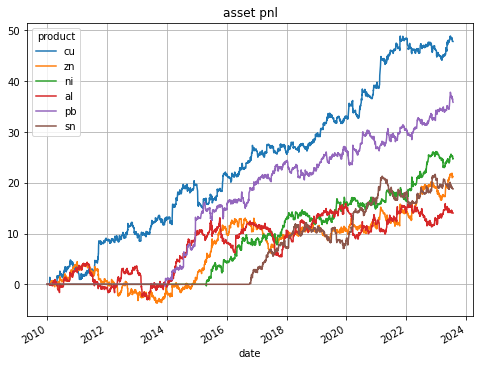

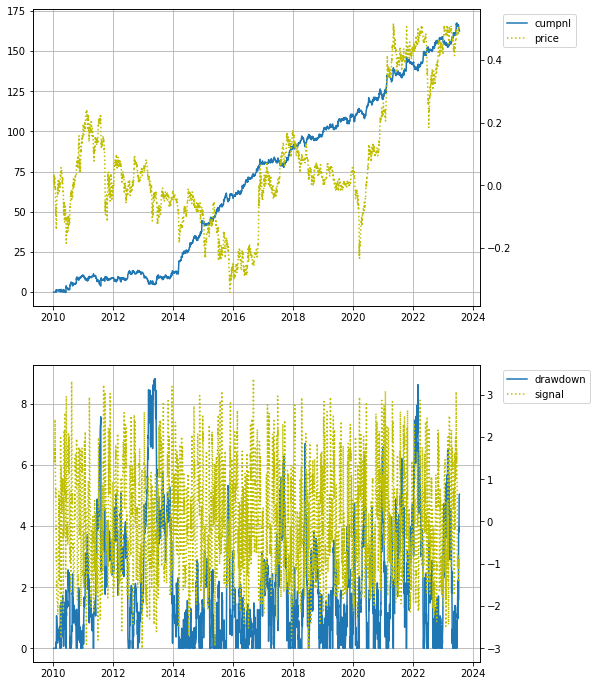

In [42]:
cutoff='2010-01-01'
feature='lme_0m_3m_spd'
signal_cap = None
#param_rng = [5, 25, 5]
#signal_func = 'ma_dff_sgn'

param_rng = [10, 20, 2]
#signal_func = 'ma_dff_sgn'
signal_func = 'zscore'
bullish = True
#freq='W-Fri'
signal_df = pd.DataFrame(index=bdates, columns=empiric_assets)
for asset in empiric_assets:
    if asset in ['cu', 'al', 'zn']:
        feature = 'lme_3m_15m_spd'
    else:
        feature = 'lme_0m_3m_spd'
    feature_ts = spot_df[asset + '_' + feature].reindex(index=cdates).ffill().reindex(index=bdates)
    #feature_ts = spot_df[feature].ffill().reindex(index=pd.date_range(start=df.index[0], end=df.index[-1], freq=freq)).ffill().dropna()
    #feature_ts = spot_df[feature].dropna()

    #label_func = lunar_label
    #label_args = {}
    # label_func = calendar_label
    # label_args = {'anchor_date': {'month': 1, 'day': 1}}
    #group_col = 'label_wk'
    #group_col = 'label_day'
    #feature_ts = yoy_generic(feature_ts, label_func=label_func, group_col='label_day', func=chg_func, label_args=label_args)

    #feature_ts = feature_ts.diff(5)
    
    signal_ts = calc_conv_signal(feature_ts, signal_func=signal_func, param_rng=param_rng, signal_cap=signal_cap)
    # signal_ts = seasonal_score(feature_ts.to_frame(), backward=10, forward=10, rolling_years=3, min_obs=10)
    # signal_ts = seasonal_score(feature_ts.to_frame(), backward=15, forward=15, rolling_years=3, min_obs=30)
    # signal_ts = feature_ts

    if not bullish:
        signal_ts = -signal_ts

    signal_ts = signal_ts.reindex(index=cdates).ffill().reindex(index=df_pxchg.index).dropna()
    
    signal_df[asset] = signal_ts.shift(1)

holding = generate_holding_from_signal(signal_df, vol_df, risk_scaling=1.0, asset_scaling=False)
bt_metrics = MetricsBase(holdings=holding[empiric_assets][cutoff:],
                         returns=df_pxchg[empiric_assets][cutoff:])

pnl_stats = bt_metrics.calculate_pnl_stats(shift=0, use_log_returns=False, tenors=pnl_tenors)

print(pnl_stats['sharpe'])
print(pnl_stats['asset_sharpe_stats'])

print(pd.DataFrame({key: pnl_stats[key] for key in ['pnl_per_trade', 'turnover']}))

pnl_stats['asset_cumpnl'].plot(figsize=(8,6))
plt.grid()
plt.title('asset pnl')

plot_signal_pnl(pnl_stats['portfolio_cumpnl'], signal=signal_ts, asset_price=df_pxchg[empiric_assets[0]].cumsum(), figsize=(8, 12))


standard signal

In [13]:
cutoff='2012-01-01'
signal_cap= None #[-2, 2]

feature_setup = {
    'margin': ('margin_hrc_pbf', 'qtl', [40, 60, 2], '', '', True, 'price')
}
    
feature_names = [
    ('steel_margin_lvl_fast', 1.0),
    ('strip_hsec_lvl_mid', 0.0),
]

sig_ts_list = []

for feature_name, weight in feature_names:
    if feature_name in signal_store:
        feature, signal_func, param_rng, proc_func, chg_func, bullish, freq = signal_store[feature_name]
    else:
        feature, signal_func, param_rng, proc_func, chg_func, bullish, freq = feature_setup[feature_name]
    
    if freq == 'price':
        feature_ts = spot_df[feature].ffill().reindex(index=df.index).ffill()
    elif len(freq) > 0:
        feature_ts = spot_df[feature].ffill().reindex(index=pd.date_range(start=df.index[0], end=df.index[-1], freq=freq)).ffill()
    else:
        feature_ts = spot_df[feature].dropna()

    if 'yoy' in proc_func:
        if 'lunar' in proc_func:
            label_func = lunar_label
            label_args = {}
        else:
            label_func = calendar_label
            label_args = {'anchor_date': {'month': 1, 'day': 1}}
        if '_wk' in proc_func:
            group_col = 'label_wk'
        else:
            group_col = 'label_day'
        feature_ts = yoy_generic(feature_ts, label_func=label_func, group_col='label_day', func=chg_func, label_args=label_args)
    elif 'df' in proc_func:
        n_diff = int(proc_func[2:])
        feature_ts = getattr(feature_ts, chg_func)(n_diff)

    if signal_func == 'seasonal_score_w':
        signal_ts = seasonal_score(feature_ts.to_frame(), backward=10, forward=10, rolling_years=3, min_obs=10).reindex(index=df.index).ffill()
    elif signal_func == 'seasonal_score_d':
        signal_ts = seasonal_score(feature_ts.to_frame(), backward=15, forward=15, rolling_years=3, min_obs=30)
    elif len(signal_func)>0:
        feature_ts = feature_ts.reindex(index=df.index).ffill()
        signal_ts = calc_conv_signal(feature_ts, signal_func=signal_func, param_rng=param_rng, signal_cap=signal_cap)
    else:
        signal_ts = feature_ts.reindex(index=df.index).ffill()

    if not bullish:
        signal_ts = -signal_ts
    
    signal_ts = signal_ts.reindex(index=date_rng).ffill().reindex(index=df_pxchg.index)
    sig_ts_list.append(signal_ts * weight)

signal_ts = pd.concat(sig_ts_list, axis=1).mean(axis=1)

KeyError: 'margin_hrc_sh'

In [16]:
signal_ts = signal_ts.reindex(index=date_rng).ffill().reindex(index=df_pxchg.index)
signal_df = pd.DataFrame(dict([(asset, signal_ts.shift(1)) for asset in empiric_assets]))

holding = generate_holding_from_signal(signal_df, vol_df, risk_scaling=1.0, asset_scaling=False)
bt_metrics = MetricsBase(holdings=holding[empiric_assets][cutoff:],
                         returns=df_pxchg[empiric_assets][cutoff:])

pnl_stats = bt_metrics.calculate_pnl_stats(shift=0, use_log_returns=False, tenors=pnl_tenors)

print(pnl_stats['sharpe'])
print(pnl_stats['asset_sharpe_stats'])

print(pd.DataFrame({key: pnl_stats[key] for key in ['pnl_per_trade', 'turnover']}))

pnl_stats['asset_cumpnl'].plot(figsize=(8,6))
plt.grid()
plt.title('asset pnl')

plot_signal_pnl(pnl_stats['portfolio_cumpnl'], signal=signal_ts, asset_price=df_pxchg[empiric_assets[0]].cumsum(), figsize=(8, 12))


NameError: name 'date_rng' is not defined

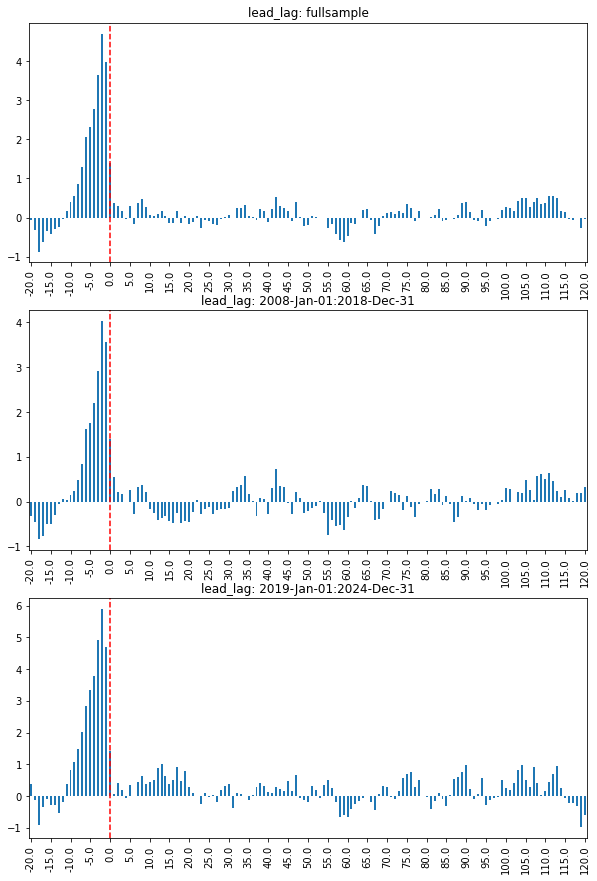

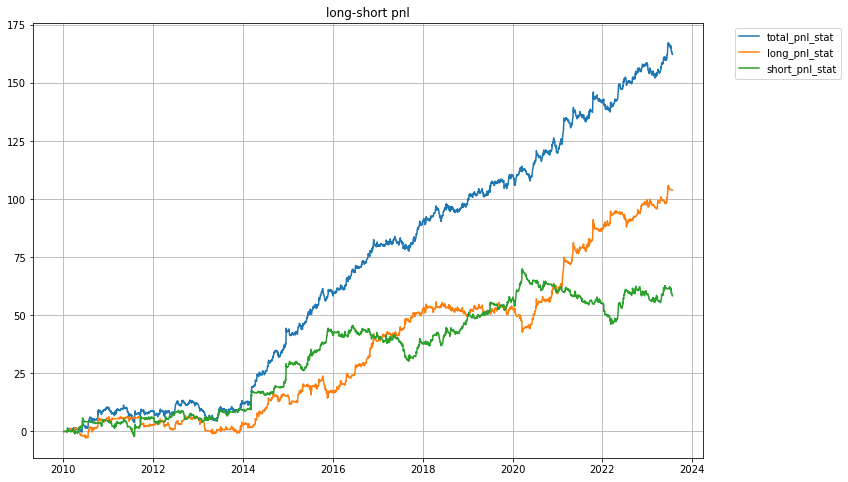

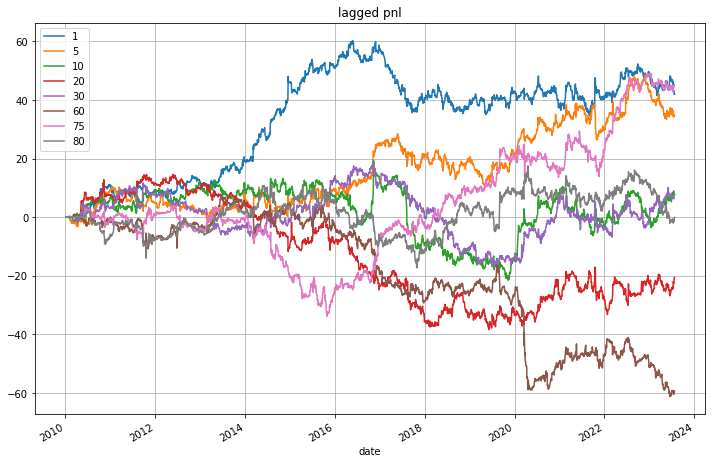

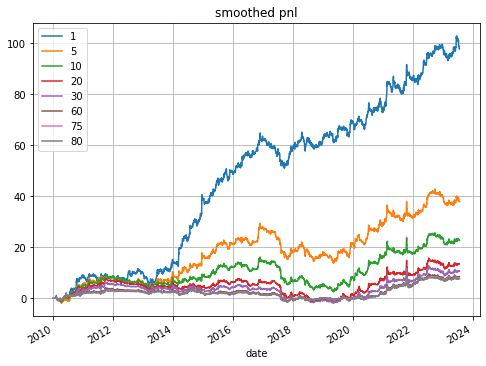

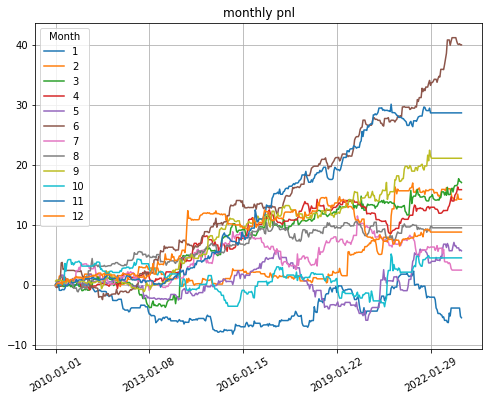

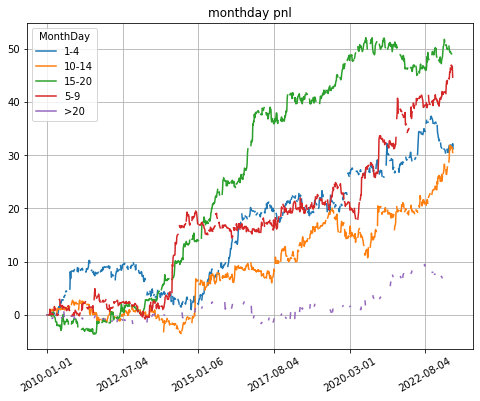

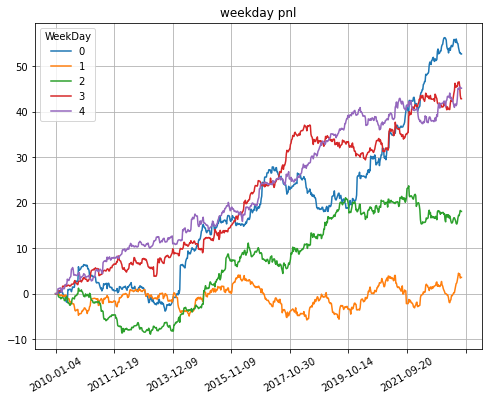

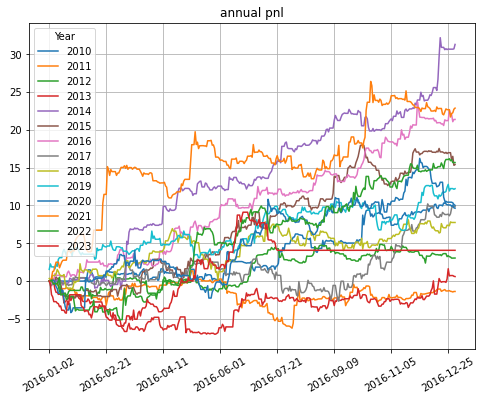

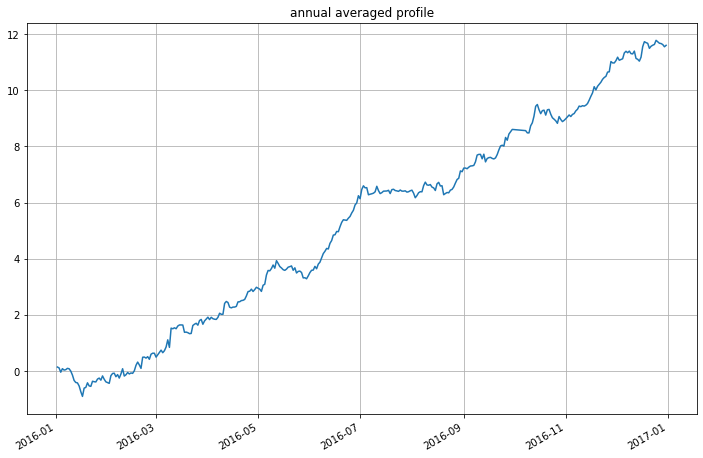

In [29]:
lead_lag_config = {
    'll_left': -20,
    'll_right': 120,
    'll_spacing': 5,
    'll_sub_win': [(datetime.date(2008, 1, 1), datetime.date(2018, 12, 31)), 
                   (datetime.date(2019, 1, 1), datetime.date(2024, 12, 31)),],
}

ll_keys = ['fullsample'] + ['%s:%s' % (sd.strftime('%Y-%b-%d'), ed.strftime('%Y-%b-%d')) for sd, ed in lead_lag_config['ll_sub_win']]


ll_left = lead_lag_config['ll_left']
ll_right = lead_lag_config['ll_right']
spacing = lead_lag_config['ll_spacing']

leadlag_df = bt_metrics.lead_lag(ll_limit_left=ll_left, 
                                 ll_limit_right=ll_right,
                                 ll_sub_windows=lead_lag_config['ll_sub_win'])

fig, ax = plt.subplots(len(ll_keys), 1)
fig.set_figheight(15)
fig.set_figwidth(10)

for i, key in enumerate(ll_keys):
    ts = leadlag_df['leadlag_sharpes'].loc[key]
    ts.plot(kind='bar', ax = ax[i], title = f'lead_lag: {key}')
    new_ticks = np.linspace(ll_left, ll_right, (ll_right-ll_left)//spacing+1)
    ax[i].set_xticks(np.interp(new_ticks, ts.index, np.arange(ts.size)))
    ax[i].set_xticklabels(new_ticks)
    ax[i].axvline(x=-ll_left, color='red', linestyle='--')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ls_pnl = bt_metrics.long_short_pnl()
for key in ls_pnl:
    ax.plot(ls_pnl[key]['portfolio_cumpnl'].index, ls_pnl[key]['portfolio_cumpnl'].values, '-', label=key)
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, bbox_to_anchor=(1.04, 1), loc='upper left')
ax.grid()
plt.title("long-short pnl")
plt.show()

lagged = bt_metrics.lagged_pnl(lags=[1, 5, 10, 20, 30, 60, 75, 80])
lagged['cumpnl'].plot()
#print('lagged PNL\n', lagged['sharpe'])
plt.grid()
plt.title('lagged pnl')
plt.show()

smoothed = bt_metrics.smoothed_pnl(smooth_hls=[1, 5, 10, 20, 30, 60, 75, 80])
smoothed['cumpnl'].plot(figsize=(8, 6))
#print('smoothed PNL\n', smoothed['sharpe'])
plt.grid()
plt.title('smoothed pnl')
plt.show()

#tilt_timing = bt_metrics.tilt_timing(tilt_rolling_window=1*244) # default 3 years  tilt_rolling_window = 3 * 244 

seasonal_pnl = bt_metrics.seasonal_pnl()
cumpnl = seasonal_pnl['cumlog_pnl']
cumpnl.set_index(cumpnl.index.astype('str')).plot(rot=30, figsize = (8, 6))
#print('seasonal sharpe stats\n', seasonal_pnl['sharpe_stats'])
plt.grid()
plt.title('monthly pnl')
plt.show()


monthday_pnl = bt_metrics.monthday_pnl()
cumpnl = monthday_pnl['cumlog_pnl']
cumpnl.set_index(cumpnl.index.astype('str')).plot(rot=30, figsize = (8, 6))
#print('monthday sharpe stats\n', monthday_pnl['sharpe_stats'])
plt.grid()
plt.title('monthday pnl')
plt.show()


week_pnl = bt_metrics.week_pnl()
cumpnl = week_pnl['cumlog_pnl']
cumpnl.set_index(cumpnl.index.astype('str')).plot(rot=30, figsize = (8, 6))
#print('week sharpe stats\n', week_pnl['sharpe_stats'])
plt.grid()
plt.title('weekday pnl')
plt.show()


annual_pnl = bt_metrics.annual_pnl()
cumpnl = annual_pnl['cumlog_pnl']
cumpnl.set_index(cumpnl.index.astype('str')).plot(rot=30, figsize = (8, 6))
#print('annual sharpe stats\n', annual_pnl['sharpe_stats'])
plt.grid()
plt.title('annual pnl')
plt.show()

annual_pnl['cumlog_pnl'].mean(axis=1).plot()
plt.grid()
plt.title('annual averaged profile')
plt.show()

# turnover = bt_metrics.turnover()
# print(turnover)

# batch feature exploration

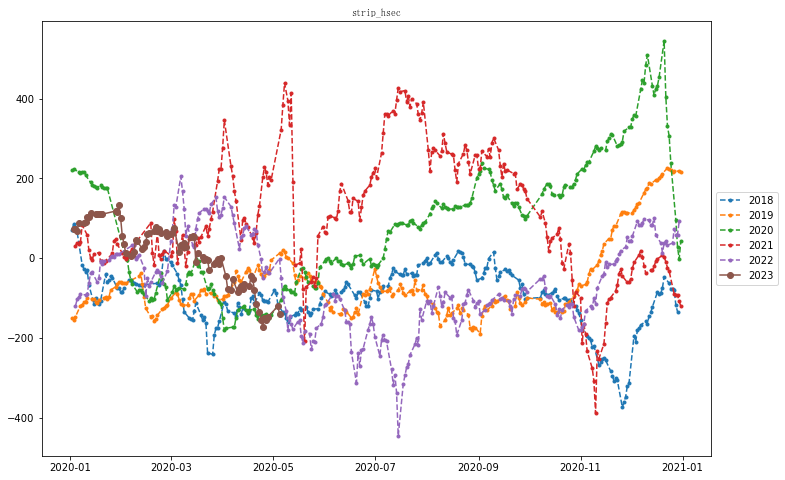

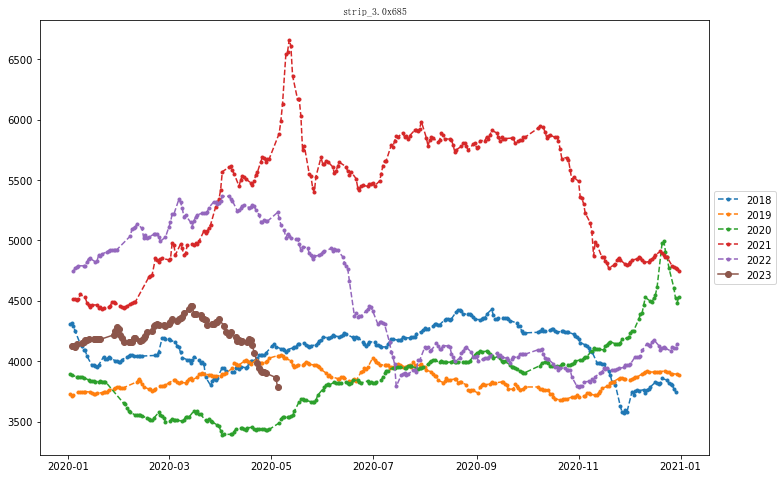

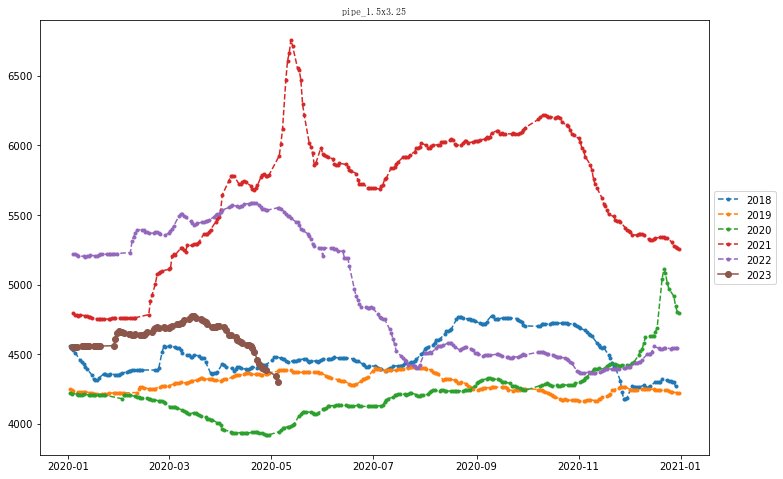

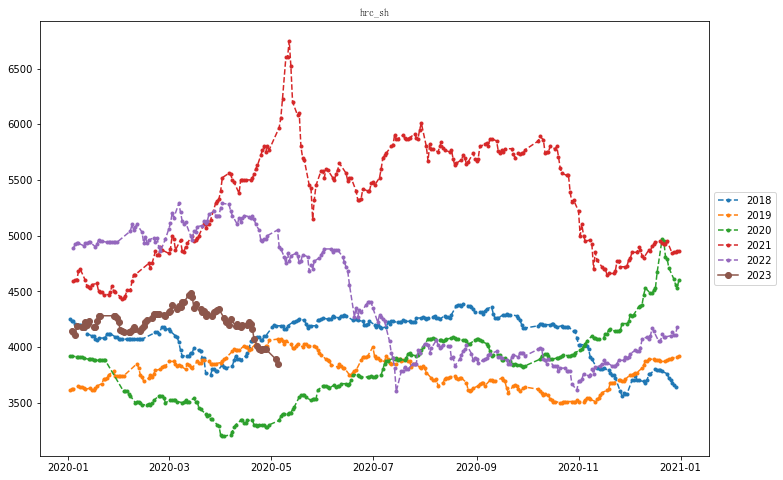

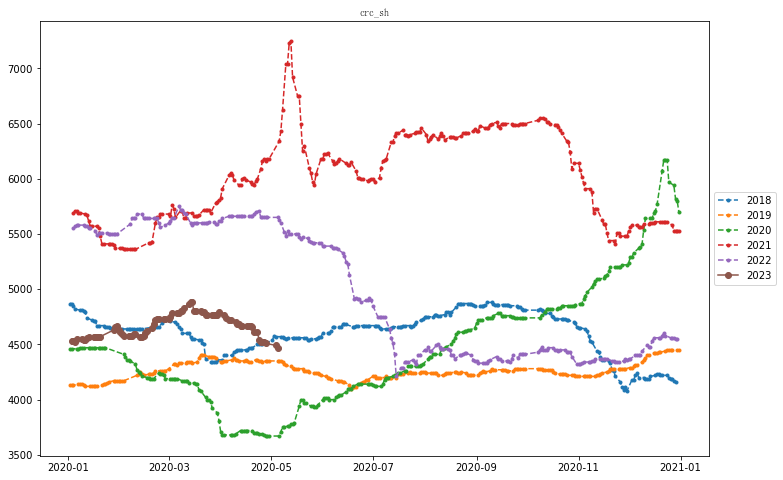

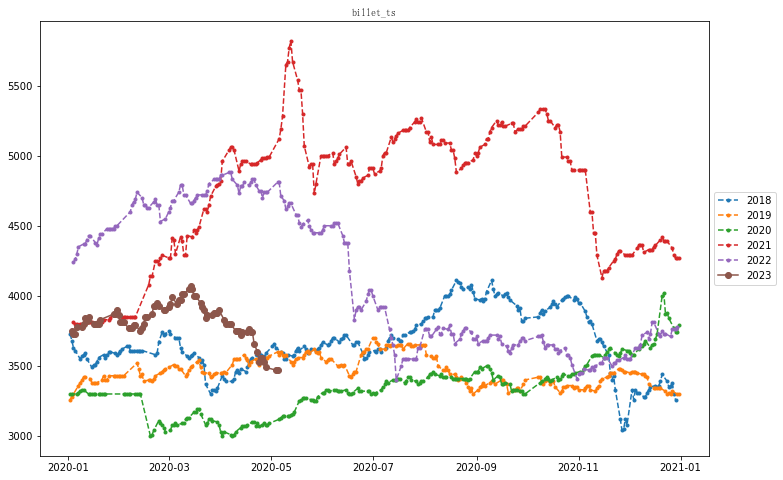

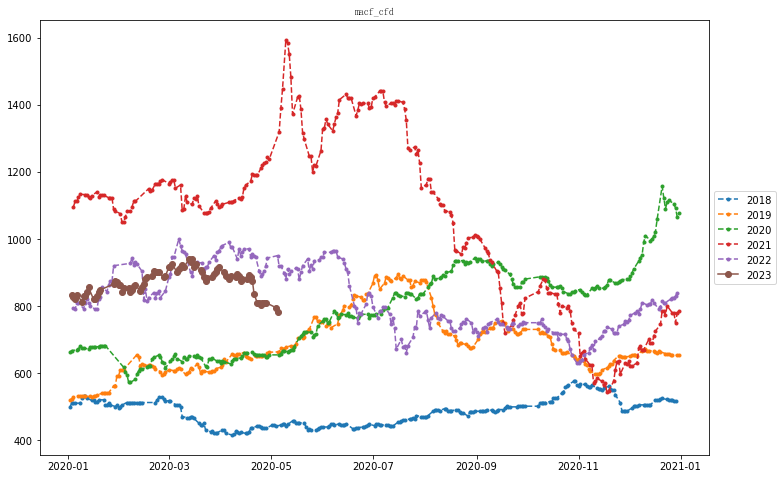

In [116]:
feature_list = [
#     'margin_hrc_sh', 
    'strip_hsec',
    'strip_3.0x685',
    'pipe_1.5x3.25',    
    'hrc_sh',
    'crc_sh',
    'billet_ts',
    'macf_cfd',
#     'gi_0.5_sh',
#     'hsec_400x200',
#     'highwire_6.5',
#     'angle_50x5',
#     'ibeam_25',
#     'channel_16',

#     'import_arb', 'pbf_prem', 'plt65_62',
#     'io_laytime_45ports', 'io_inv_imp_31ports',
#     'io_invdays_imp_mill(64)', 'io_inv_mill(64)', 'io_inv_imp_mill',
#     'io_removal_port_41',
#     'io_loading_14ports_ausbzl',
]

udf = spot_df[feature_list].dropna(how='all')
# lunar_seasonal = True

# if lunar_seasonal:
#     seasonal_signal = tstool.lunar_label(udf)
#     seasonal_signal = tstool.seasonal_group_score(
#         seasonal_signal, score_cols=feature_list, yr_col='lunar_cny',
#         group_col='lunar_wks', min_obs=3, backward=2, forward=2, rolling_years=3)
#     seasonal_signal = seasonal_signal.reindex(index=df.index).ffill()

for feature in udf.columns:
    dataseries.plot_seasonal_df(udf[feature].dropna(), cutoff='2018-01-01', title=feature)
    
signal_raw = udf[feature_list].reindex(index=df.index).ffill()


rb:strip_hsec -> SR: 1.00 -- PNL per trade: 33.08 -- Turnover: 26.72
rb:strip_3.0x685 -> SR: 1.07 -- PNL per trade: 55.20 -- Turnover: 17.46
rb:pipe_1.5x3.25 -> SR: 0.85 -- PNL per trade: 53.25 -- Turnover: 14.26
rb:hrc_sh -> SR: 1.11 -- PNL per trade: 46.67 -- Turnover: 21.92
rb:crc_sh -> SR: 1.03 -- PNL per trade: 60.39 -- Turnover: 15.17
rb:billet_ts -> SR: 0.85 -- PNL per trade: 30.21 -- Turnover: 26.18
rb:macf_cfd -> SR: 1.18 -- PNL per trade: 77.03 -- Turnover: 13.00


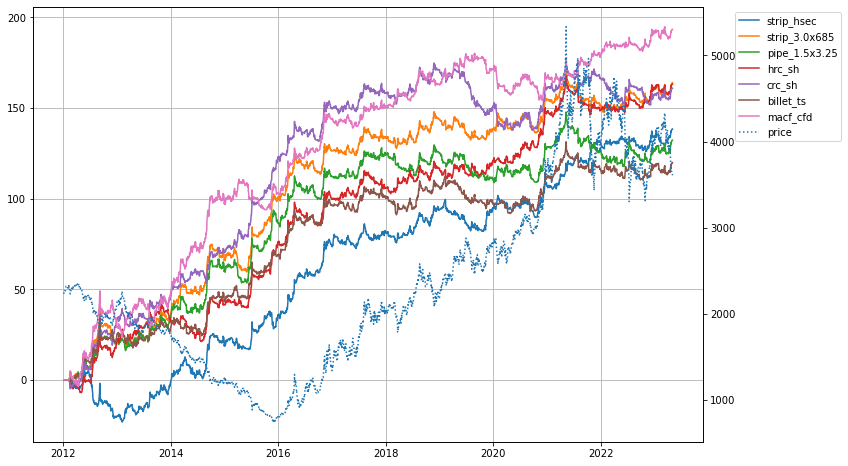

hc:strip_hsec -> SR: 1.25 -- PNL per trade: 42.52 -- Turnover: 28.27
hc:strip_3.0x685 -> SR: 0.96 -- PNL per trade: 49.43 -- Turnover: 19.23
hc:pipe_1.5x3.25 -> SR: 0.72 -- PNL per trade: 49.98 -- Turnover: 13.95
hc:hrc_sh -> SR: 1.26 -- PNL per trade: 54.48 -- Turnover: 23.52
hc:crc_sh -> SR: 0.87 -- PNL per trade: 53.23 -- Turnover: 16.00
hc:billet_ts -> SR: 0.71 -- PNL per trade: 27.15 -- Turnover: 26.33
hc:macf_cfd -> SR: 0.89 -- PNL per trade: 48.24 -- Turnover: 17.91


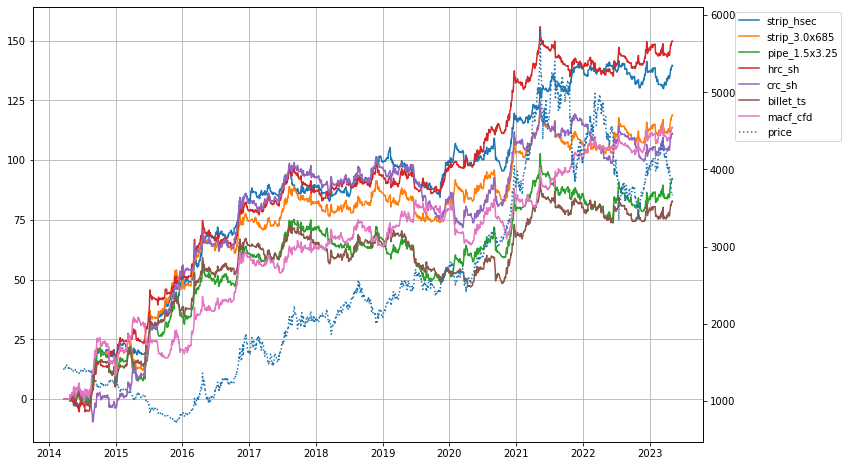

i:strip_hsec -> SR: 1.37 -- PNL per trade: 74.96 -- Turnover: 26.70
i:strip_3.0x685 -> SR: 1.02 -- PNL per trade: 81.14 -- Turnover: 18.90
i:pipe_1.5x3.25 -> SR: 0.76 -- PNL per trade: 79.20 -- Turnover: 14.08
i:hrc_sh -> SR: 1.05 -- PNL per trade: 70.10 -- Turnover: 23.09
i:crc_sh -> SR: 0.73 -- PNL per trade: 67.10 -- Turnover: 16.17
i:billet_ts -> SR: 0.85 -- PNL per trade: 49.90 -- Turnover: 26.78
i:macf_cfd -> SR: 1.52 -- PNL per trade: 132.16 -- Turnover: 16.51


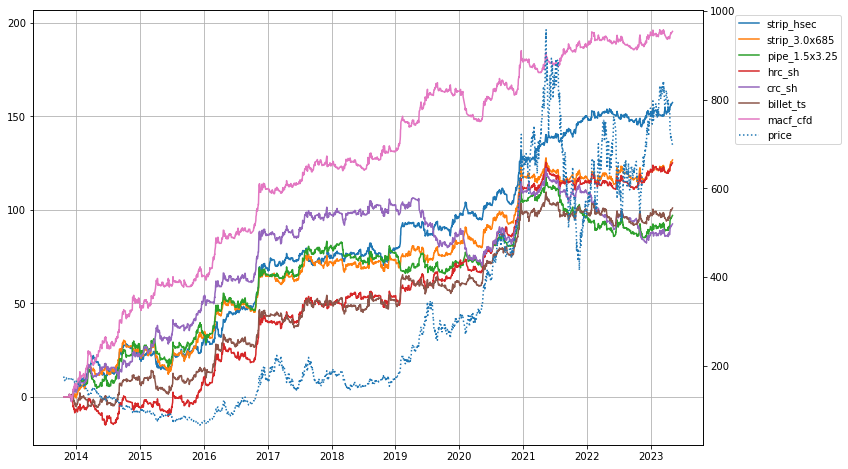

j:strip_hsec -> SR: 1.26 -- PNL per trade: 53.79 -- Turnover: 27.92
j:strip_3.0x685 -> SR: 1.37 -- PNL per trade: 89.78 -- Turnover: 17.88
j:pipe_1.5x3.25 -> SR: 1.49 -- PNL per trade: 121.06 -- Turnover: 14.14
j:hrc_sh -> SR: 1.07 -- PNL per trade: 59.06 -- Turnover: 22.09
j:crc_sh -> SR: 1.50 -- PNL per trade: 115.20 -- Turnover: 15.14
j:billet_ts -> SR: 1.23 -- PNL per trade: 56.59 -- Turnover: 26.66
j:macf_cfd -> SR: 1.32 -- PNL per trade: 109.48 -- Turnover: 13.21


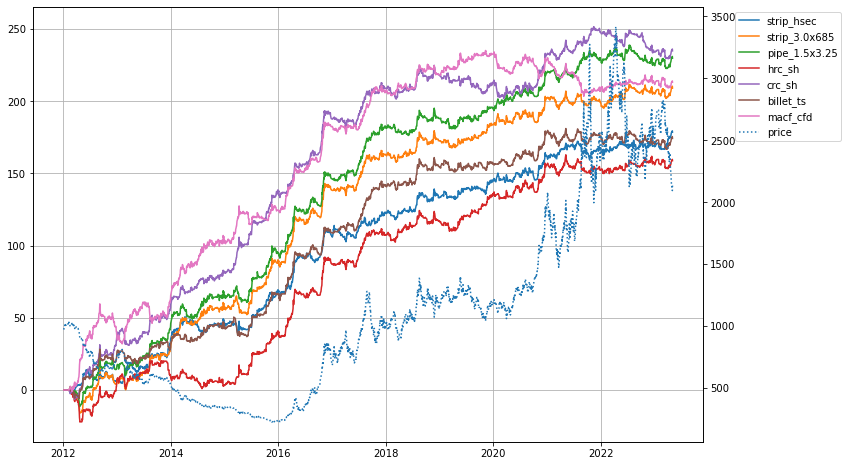

jm:strip_hsec -> SR: 1.11 -- PNL per trade: 47.05 -- Turnover: 27.42
jm:strip_3.0x685 -> SR: 1.10 -- PNL per trade: 69.23 -- Turnover: 18.61
jm:pipe_1.5x3.25 -> SR: 1.11 -- PNL per trade: 91.50 -- Turnover: 13.80
jm:hrc_sh -> SR: 0.74 -- PNL per trade: 38.50 -- Turnover: 23.06
jm:crc_sh -> SR: 1.26 -- PNL per trade: 93.10 -- Turnover: 15.35
jm:billet_ts -> SR: 0.85 -- PNL per trade: 37.64 -- Turnover: 27.50
jm:macf_cfd -> SR: 0.93 -- PNL per trade: 65.74 -- Turnover: 15.77


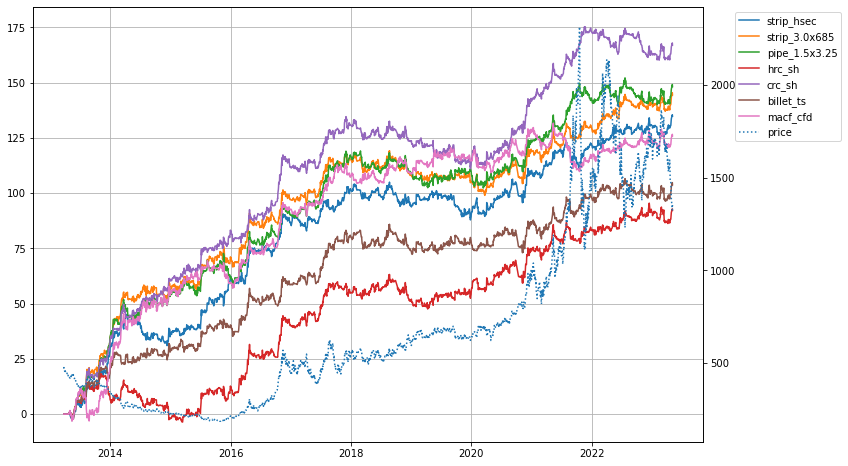

SF:strip_hsec -> SR: 0.18 -- PNL per trade: 6.28 -- Turnover: 30.83
SF:strip_3.0x685 -> SR: 0.70 -- PNL per trade: 35.25 -- Turnover: 21.70
SF:pipe_1.5x3.25 -> SR: 0.89 -- PNL per trade: 61.14 -- Turnover: 15.48
SF:hrc_sh -> SR: 0.94 -- PNL per trade: 42.61 -- Turnover: 24.70
SF:crc_sh -> SR: 1.28 -- PNL per trade: 86.06 -- Turnover: 15.70
SF:billet_ts -> SR: 0.69 -- PNL per trade: 28.08 -- Turnover: 27.31
SF:macf_cfd -> SR: 0.66 -- PNL per trade: 31.76 -- Turnover: 22.86


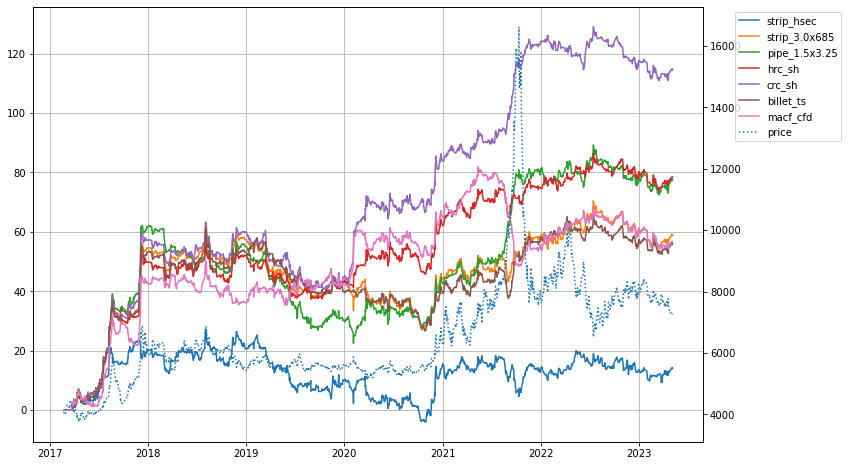

FG:strip_hsec -> SR: 1.09 -- PNL per trade: 38.09 -- Turnover: 29.64
FG:strip_3.0x685 -> SR: 0.48 -- PNL per trade: 25.14 -- Turnover: 20.07
FG:pipe_1.5x3.25 -> SR: 0.31 -- PNL per trade: 21.01 -- Turnover: 14.80
FG:hrc_sh -> SR: 0.87 -- PNL per trade: 38.18 -- Turnover: 23.47
FG:crc_sh -> SR: 0.40 -- PNL per trade: 24.92 -- Turnover: 16.19
FG:billet_ts -> SR: 0.76 -- PNL per trade: 29.74 -- Turnover: 26.37
FG:macf_cfd -> SR: 0.65 -- PNL per trade: 33.69 -- Turnover: 19.86


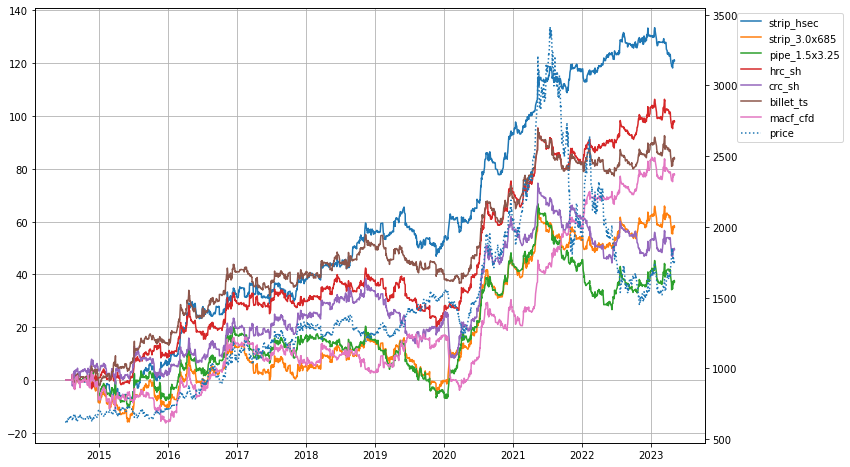

In [118]:
cutoff = '2012-01-01'
signal_func = 'qtl'
param_rng = [20, 42, 2]
signal_cap = None # [-2, 2]
product_list = ['rb', 'hc', 'i', 'j', 'jm', 'SF', 'FG', ] # 'v', 'cu', 'al', 'ss', 'UR', 'SA', 'ru'

for asset in product_list:
    if '_' in asset:
        price_ts = (1 + beta_ret_dict[asset]).cumprod().to_frame('price')[cutoff:]
    else:
        price_ts = df[(asset, 'c1', 'close')].dropna().to_frame('price')[cutoff:]
    pnl_list = [price_ts]
    for feature in feature_list:
        feature_ts = udf[feature].reindex(index=price_ts.index).ffill()
        #feature_ts = feature_ts.pct_change(5)
        #feature_ts = tstool.lunar_yoy(feature_ts, group_col='lunar_days', func='pct_change')
        #feature_ts = tstool.seasonal_score(feature_ts.to_frame())
        signal_ts = calc_conv_signal(feature_ts, signal_func=signal_func, param_rng=param_rng, signal_cap=signal_cap)
        asset_df = pd.concat([price_ts, signal_ts], axis=1)
        asset_df.columns = ['price', 'signal']
        asset_df['signal'] = asset_df['signal'].apply(lambda x: x).ffill()
        asset_df = asset_df.dropna(subset=['price'])
        asset_df['position'] = (asset_df['signal']/asset_df['price'].pct_change().rolling(20).std()).shift(1).fillna(0)
        asset_df['pnl'] = (asset_df['position'].shift(1) * asset_df['price'].pct_change()).fillna(0)
        
        sr = np.sqrt(244) * asset_df['pnl'].mean()/asset_df['pnl'].std()
        pnl_per_trade = 100 * 100 * asset_df['pnl'].mean()/asset_df['position'].diff().abs().mean()
        turnover = 100 * asset_df['position'].diff().abs().mean()/asset_df['position'].abs().mean()
        print(f'{asset}:{feature} -> SR: {sr:.2f} -- PNL per trade: {pnl_per_trade:.2f} -- Turnover: {turnover:.2f}')
        pnl_list.append(asset_df['pnl'].cumsum().to_frame(feature))
    pnl_df = pd.concat(pnl_list, axis=1)
    dataseries.plot_df_on_2ax(pnl_df, left_on=feature_list, right_on=['price'])
    

# signal grid search run

In [ ]:
signal_list = []

for feature in feature_list:
    for win in [20, 40, 60, 80, 120, 240]:
        signal_name = f"{feature}:ma:{win}"
        signal_raw[signal_name] = signal_raw[feature] - signal_raw[feature].rolling(win).mean()
        signal_raw[signal_name] = dh.risk_normalized(signal_raw[signal_name], 60)
        signal_list.append(signal_name)
        
        signal_name = f"{feature}:ewmac:{win}"
        signal_raw[signal_name] = dh.ewmac(signal_raw[feature], win_s=win/10, ls_ratio=2)
        signal_raw[signal_name] = dh.risk_normalized(signal_raw[signal_name], 60)
        signal_list.append(signal_name)

#         signal_name = f"{feature}:convewm:{win}"
#         signal_raw[signal_name] = dh.conv_ewm(signal_raw[feature], h1s=[win//10, win//10*2], h2s=[win//10*3, win//10*6])
#         signal_raw[signal_name] = dh.risk_normalized(signal_raw[signal_name], 60)
#         signal_list.append(signal_name)
        
        signal_name = f"{feature}:zscore:{win}"
        signal_raw[signal_name] = dh.zscore_roll(signal_raw[feature], win=win)
        signal_list.append(signal_name) 
        
        signal_name = f"{feature}:zscore_dff20:{win}"
        signal_raw[signal_name] = dh.zscore_roll(signal_raw[feature].diff(20), win=win)
        signal_list.append(signal_name) 
        
        signal_name = f"{feature}:qtl:{win}"
        signal_raw[signal_name] = dh.pct_score(signal_raw[feature], win=win)*2
        signal_list.append(signal_name) 
        
        signal_name = f"{feature}:qtl_dff20:{win}"
        signal_raw[signal_name] = dh.pct_score(signal_raw[feature].diff(20), win=win)*2
        signal_list.append(signal_name)
        
        signal_name = f"{feature}:lunar_wks_score:{win}"
        signal_raw[signal_name] = seasonal_signal[feature]
        signal_list.append(signal_name)
        
        signal_prefix = f"{feature}:seasonal_score"
        signal_raw[signal_prefix] = tstool.seasonal_score(signal_raw[feature].to_frame())
        signal_name = f"{signal_prefix}_pct:{win}"
        signal_raw[signal_name] = dh.pct_score(signal_raw[feature], win=win)*2
        signal_list.append(signal_name) 
        signal_name = f"{signal_prefix}_zscore:{win}"
        signal_raw[signal_name] = dh.zscore_roll(signal_raw[feature], win=win)
        signal_list.append(signal_name)
        
        signal_prefix = f"{feature}:yoy"
        signal_raw[signal_prefix] = signal_raw[feature]/signal_raw[feature].shift(244)-1
        signal_name = f"{signal_prefix}_pct:{win}"
        signal_raw[signal_name] = dh.pct_score(signal_raw[feature], win=win)*2
        signal_list.append(signal_name) 
        signal_name = f"{signal_prefix}_zscore:{win}"
        signal_raw[signal_name] = dh.zscore_roll(signal_raw[feature], win=win)
        signal_list.append(signal_name)

        signal_prefix = f"{feature}:lunar_yoy"
        signal_raw[signal_prefix] = tstool.lunar_yoy(signal_raw[feature], group_col='lunar_days', func='pct_change')
        signal_name = f"{signal_prefix}_pct:{win}"
        signal_raw[signal_name] = dh.pct_score(signal_raw[feature], win=win)*2
        signal_list.append(signal_name) 
        signal_name = f"{signal_prefix}_zscore:{win}"
        signal_raw[signal_name] = dh.zscore_roll(signal_raw[feature], win=win)
        signal_list.append(signal_name)
        
signal_raw = signal_raw.reindex(index=df.index).ffill()

In [ ]:
product_list = ['rb', 'hc', 'i', 'j', 'jm', 'v', 'FG', 'SM', 'SF']
cutoff = pd.Timestamp('2012-07-01')

for sig in signal_list:
    print(sig)
    pnl_by_asset = {}
    pnl_df = pd.DataFrame()
    pos_df = pd.DataFrame()
    for asset in product_list:
        signal = signal_raw[sig]
        asset_df = pd.concat([df[(asset, 'c1', 'close')], signal], axis=1)
        asset_df.columns = ['price', 'signal']
        asset_df['signal'] = asset_df['signal'].apply(lambda x: x).ffill()
        asset_df = asset_df.dropna(subset=['price']).ffill()
        asset_df['position'] = (asset_df['signal']/asset_df['price'].pct_change().rolling(20).std()).shift(1).fillna(0)
        asset_df['pnl'] = (asset_df['position'].shift(1) * asset_df['price'].pct_change()).fillna(0)
        
        sr = np.sqrt(244) * asset_df['pnl'].mean()/asset_df['pnl'].std()
        pnl_per_trade = 100 * 100 * asset_df['pnl'].mean()/asset_df['position'].diff().abs().mean()
        turnover = 100 * asset_df['position'].diff().abs().mean()/asset_df['position'].abs().mean()
        print(f'{asset} -> SR: {sr:.2f} -- PNL per trade: {pnl_per_trade:.2f} -- Turnover: {turnover:.2f}')
        
        pnl_by_asset[asset] = asset_df
        pnl_df[asset] = asset_df['pnl']
        pos_df[asset] = asset_df['position']
    pnl_df = pnl_df.fillna(0)
    pos_df = pos_df.ffill()
    total_sr = = np.sqrt(244) * pnl_df.sum(axis=1).mean()/pnl_df.sum(axis=1).std()
    print(f'Total SR: {total_sr:.2f}')
    
    cumpn; = pnl_df.cumsum()
    cumpnl.plot()
    plt.title(sig)
    plt.show()
    cum_pnl.sum(axis=1).plot()
    plt.title(sig)
    plt.show()
    

# Signal portfolio

In [111]:
signal_dict_full = {
    'i': [
        ('io_removal_lvl_fast', 1.0), 
        #('io_removal_lyoy_mom', 1.0),
        
        ('io_inv_mill(64)_lvl_fast', 0.5),
        #('io_inv_mill(64)_lyoy_mom', 0.5),
        
        ('io_invdays_imp_mill(64)_lvl_fast', 0.5),
        #('io_invdays_imp_mill(64)_lyoy_mom', 0.5),
        
#         ('steel_social_inv_lvl_fast', 1.0/1.0),
#         ('rebar_inv_social_lyoy_fast', 0.25/1.0),
#         ('wirerod_inv_social_lyoy_fast', 0.25/1.0),
#         ('hrc_inv_social_lyoy_fast', 0.25/1.0),
#         ('crc_inv_social_lyoy_fast', 0.25/1.0),
        
        ('margin_lvl_fast', 1.0),
        ('strip_hsec_lvl_mid', 1.0),
        ('macf_cfd_lvl_mid', 1.0),
#         ('pbf_prem_yoy', 0.5/15),
#         ('cons_steel_lyoy_slow', 1.0/1.5),
#         ('sea_export_arb_lvl_mid', 1.0/1.4),
    ],
    'rb': [
        ('io_removal_lvl_fast', 1.0), 
        #('io_removal_lyoy_mom', 1.0),
        
        ('io_inv_mill(64)_lvl_fast', 1.0),
        #('io_inv_mill(64)_lyoy_mom', 1.0),
        
#         ('rebar_inv_social_lyoy_fast', 1.0),
#         ('wirerod_inv_social_lyoy_fast', 1.0),
        
        ('margin_lvl_fast', 1.0),
        ('strip_hsec_lvl_mid', 1.0),    
    ],
    'hc': [
        ('io_removal_lvl_fast', 1.0), 
        #('io_removal_lyoy_mom', 1.0),
        
        ('io_inv_mill(64)_lvl_fast', 1.0),
        #('io_inv_mill(64)_lyoy_mom', 1.0),
        
#         ('hrc_inv_social_lyoy_fast', 1.0),
#         ('crc_inv_social_lyoy_fast', 1.0),        
        ('margin_lvl_fast', 1.0),
        ('strip_hsec_lvl_mid', 1.0),  
    ],
    'j': [
        #('io_removal_lvl_fast', 1.0), 
        #('io_removal_lyoy_mom', 1.0),
        
        #('io_inv_mill(64)_lvl_fast', 1.0),
        #('io_inv_mill(64)_lyoy_mom', 1.0),
        
#         ('steel_social_inv_lvl_fast', 1.0),
        
        ('margin_lvl_fast', 1.0),
        ('strip_hsec_lvl_mid', 1.0),    
    ],
    'jm': [
        #('io_inv_mill(64)_lvl_fast', 1.0),
        #('io_inv_mill(64)_lyoy_mom', 1.0),
        
#         ('steel_social_inv_lvl_fast', 1.0),
        
        ('margin_lvl_fast', 1.0),
        ('strip_hsec_lvl_mid', 1.0),     
    ],
    'FG': [
        #('io_inv_mill(64)_lvl_fast', 1.0),
        #('io_inv_mill(64)_lyoy_mom', 1.0),
        
        ('margin_lvl_fast', 1.0),
        ('strip_hsec_lvl_mid', 1.0),    
    ],
}

i:io_removal_lvl_fast -> SR: 1.44 -- PNL per trade: 125.18 -- Turnover: 16.32
i:io_inv_mill(64)_lvl_fast -> SR: 1.06 -- PNL per trade: 124.63 -- Turnover: 12.02
i:io_invdays_imp_mill(64)_lvl_fast -> SR: 1.08 -- PNL per trade: 96.53 -- Turnover: 16.77
i:margin_lvl_fast -> SR: 1.41 -- PNL per trade: 98.64 -- Turnover: 20.34
i:strip_hsec_lvl_mid -> SR: 1.35 -- PNL per trade: 101.73 -- Turnover: 19.64
i:macf_cfd_lvl_mid -> SR: 1.24 -- PNL per trade: 150.45 -- Turnover: 12.07
i:total -> SR: 1.92 -- PNL per trade: 173.72 -- Turnover: 17.79
io_removal_lvl_fast                 0.829607
io_inv_mill(64)_lvl_fast            0.438992
io_invdays_imp_mill(64)_lvl_fast    0.402572
margin_lvl_fast                     0.849863
strip_hsec_lvl_mid                  0.776010
macf_cfd_lvl_mid                    0.864912
dtype: float64


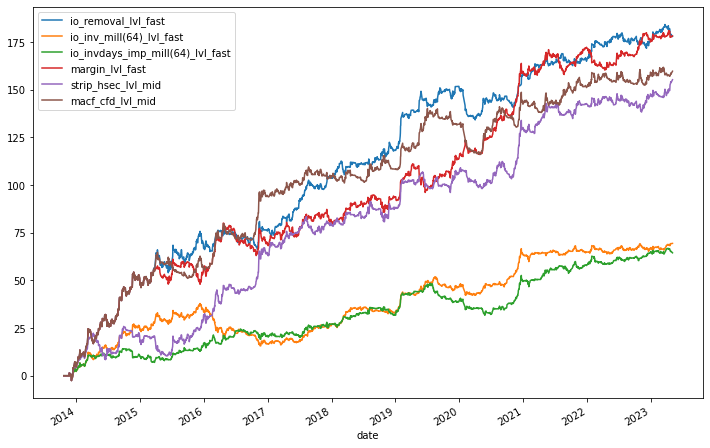

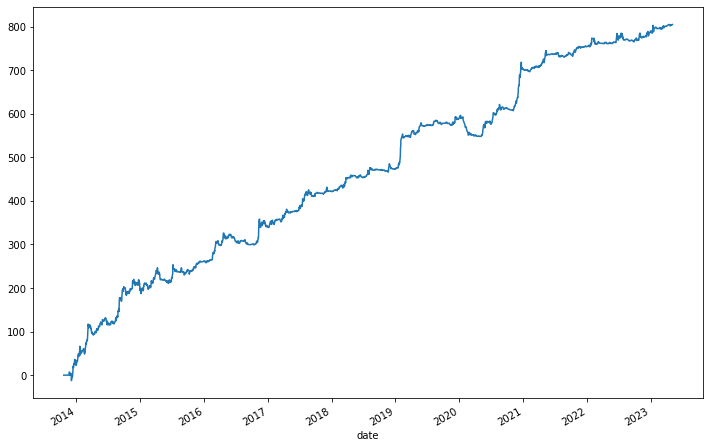

rb:io_removal_lvl_fast -> SR: 1.14 -- PNL per trade: 82.35 -- Turnover: 10.73
rb:io_inv_mill(64)_lvl_fast -> SR: 0.90 -- PNL per trade: 81.30 -- Turnover: 8.63
rb:margin_lvl_fast -> SR: 1.13 -- PNL per trade: 67.99 -- Turnover: 12.88
rb:strip_hsec_lvl_mid -> SR: 0.88 -- PNL per trade: 39.16 -- Turnover: 19.54
rb:total -> SR: 1.30 -- PNL per trade: 87.76 -- Turnover: 12.28
io_removal_lvl_fast         0.941461
io_inv_mill(64)_lvl_fast    0.974576
margin_lvl_fast             0.951824
strip_hsec_lvl_mid          0.813721
dtype: float64


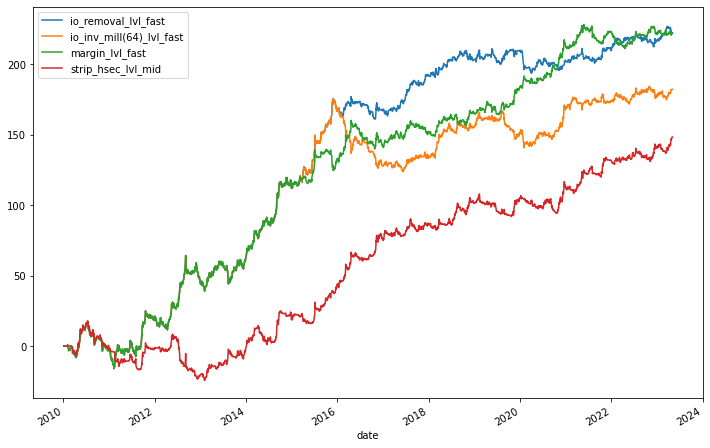

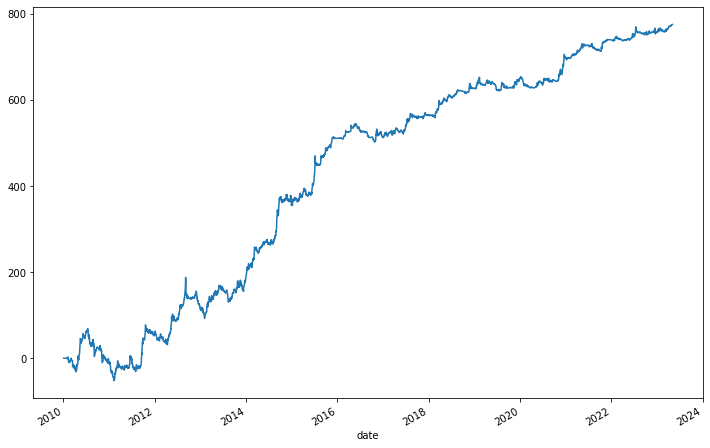

hc:io_removal_lvl_fast -> SR: 1.11 -- PNL per trade: 59.73 -- Turnover: 17.62
hc:io_inv_mill(64)_lvl_fast -> SR: 0.77 -- PNL per trade: 55.45 -- Turnover: 13.05
hc:margin_lvl_fast -> SR: 1.10 -- PNL per trade: 47.66 -- Turnover: 22.04
hc:strip_hsec_lvl_mid -> SR: 1.34 -- PNL per trade: 62.48 -- Turnover: 21.46
hc:total -> SR: 1.54 -- PNL per trade: 78.61 -- Turnover: 20.48
io_removal_lvl_fast         0.852830
io_inv_mill(64)_lvl_fast    0.902805
margin_lvl_fast             0.871381
strip_hsec_lvl_mid          0.780406
dtype: float64


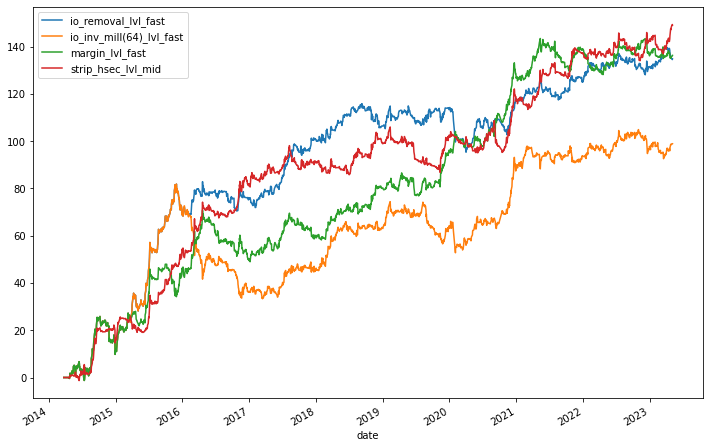

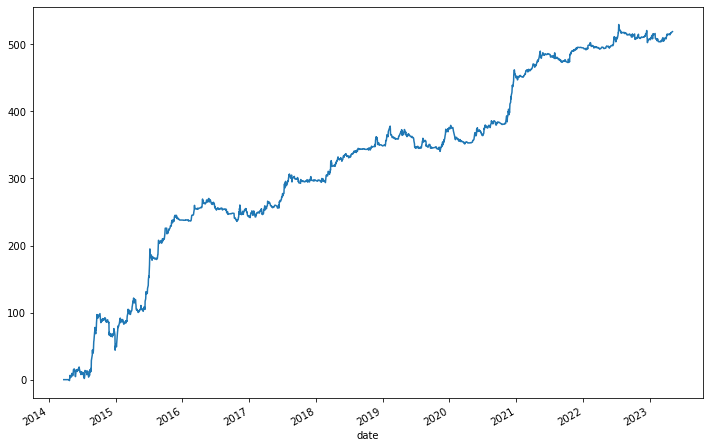

j:margin_lvl_fast -> SR: 1.72 -- PNL per trade: 123.09 -- Turnover: 14.65
j:strip_hsec_lvl_mid -> SR: 1.35 -- PNL per trade: 71.61 -- Turnover: 21.87
j:total -> SR: 1.84 -- PNL per trade: 111.75 -- Turnover: 20.35
margin_lvl_fast       0.940847
strip_hsec_lvl_mid    0.792106
dtype: float64


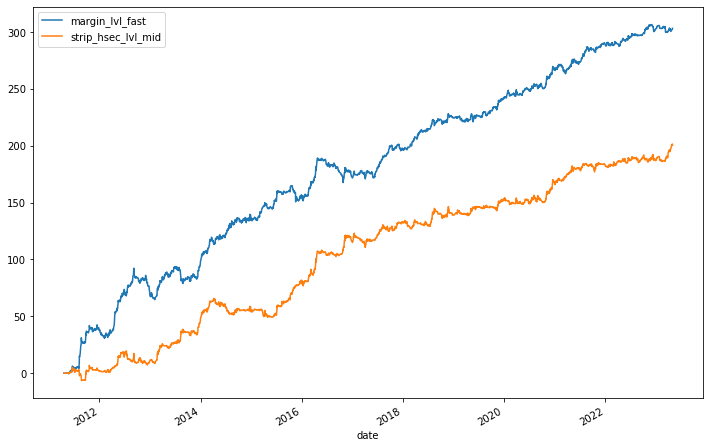

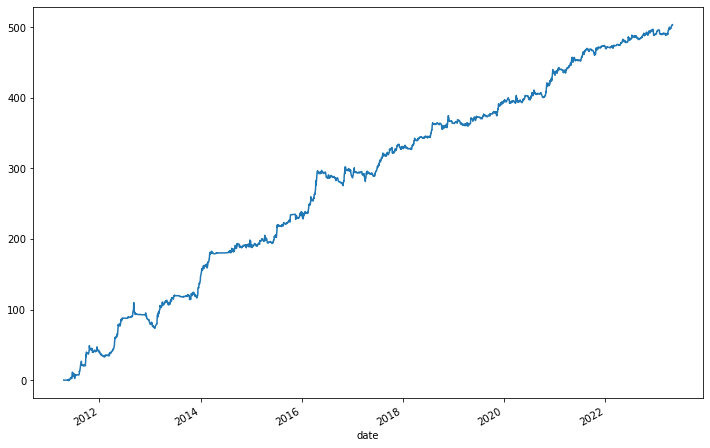

jm:margin_lvl_fast -> SR: 1.19 -- PNL per trade: 70.76 -- Turnover: 18.68
jm:strip_hsec_lvl_mid -> SR: 1.32 -- PNL per trade: 76.23 -- Turnover: 20.36
jm:total -> SR: 1.48 -- PNL per trade: 84.74 -- Turnover: 21.66
margin_lvl_fast       0.854962
strip_hsec_lvl_mid    0.761956
dtype: float64


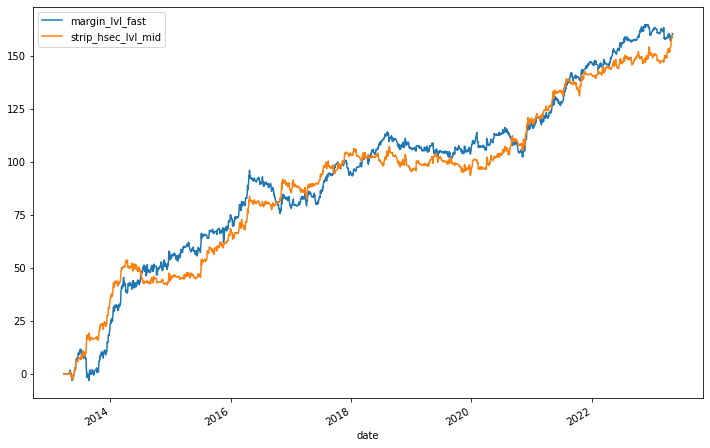

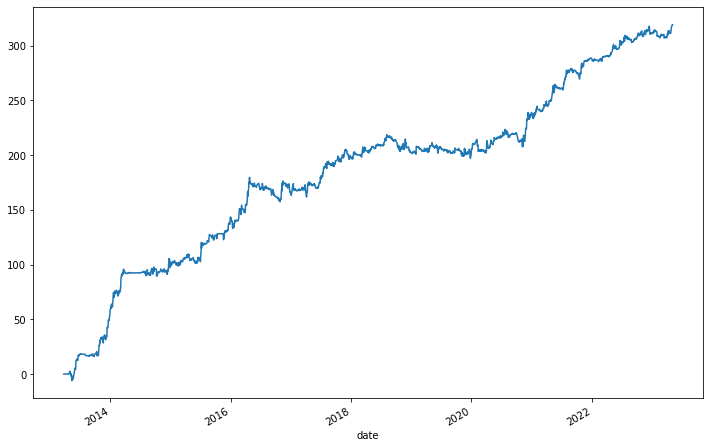

In [112]:
signal_dict = signal_dict_full

signal_diagnosis = False

pnl_dict = {}
pos_dict = {}

for asset in ['i', 'rb', 'hc', 'j', 'jm']:
    if '_' in asset:
        price_ts = (1 + beta_ret_dict[asset]).cumprod().to_frame('price')
    else:
        price_ts = df[(asset, 'c1', 'close')].dropna().to_frame('price')
    pnl_list = []
    pos_list = []
    for idx, (feature_name, weight) in enumerate(signal_dict[asset]):
        feature, signal_func, param_rng, proc_func, chg_func, bullish, freq = signal_repo[feature_name]
        if freq == 'price':
            feature_ts = spot_df[feature].ffill().reindex(index=price_ts.index).ffill()
        elif len(freq) > 0:
            feature_ts = spot_df[feature].ffill().reindex(index=pd.date_range(start=df.index[0], end=df.index[-1], freq=freq)).ffill()
        else:
            feature_ts = spot_df[feature].dropna()
        
        if 'yoy' in proc_func:
            if 'lunar' in proc_func:
                label_func = lunar_label
                label_args = {}
            else:
                label_func = calendar_label
                label_args = {'anchor_date': {'month': 1, 'day': 1}}
            if '_wk' in proc_func:
                group_col = 'label_wk'
            else:
                group_col = 'label_day'
            feature_ts = yoy_generic(feature_ts, label_func=label_func, group_col='label_day', func=chg_func, label_args=label_args)
        elif 'df' in proc_func:
            n_diff = int(proc_func[2:])
            feature_ts = getattr(feature_ts, chg_func)(n_diff)
    
        if signal_func == 'seasonal_score_w':
            signal_ts = seasonal_score(feature_ts.to_frame(), backward=10, forward=10, rolling_years=3, min_obs=10).reindex(index=df.index).ffill()
        elif signal_func == 'seasonal_score_d':
            signal_ts = seasonal_score(feature_ts.to_frame(), backward=15, forward=15, rolling_years=3, min_obs=30)
        elif len(signal_func)>0:
            feature_ts = feature_ts.reindex(index=df.index).ffill()
            signal_ts = calc_conv_signal(feature_ts, signal_func=signal_func, param_rng=param_rng, signal_cap=signal_cap)
        else:
            signal_ts = feature_ts.reindex(index=df.index).ffill()
            
        if not bullish:
            signal_ts = -signal_ts
            
        asset_df = pd.concat([price_ts, signal_ts], axis=1)
        asset_df.columns = ['price', 'signal']
        asset_df['signal'] = asset_df['signal'].apply(lambda x: x).ffill()
        asset_df = asset_df.dropna(subset=['price'])
        asset_df['position'] = (weight*asset_df['signal']/asset_df['price'].pct_change().rolling(20).std()).shift(1).fillna(0)
        asset_df['pnl'] = (asset_df['position'].shift(1) * asset_df['price'].pct_change()).fillna(0)
        
        std = asset_df['pnl'].std()
        sr = np.sqrt(244) * asset_df['pnl'].mean()/asset_df['pnl'].std()
        pnl_per_trade = 100 * 100 * asset_df['pnl'].mean()/asset_df['position'].diff().abs().mean()
        turnover = 100 * asset_df['position'].diff().abs().mean()/asset_df['position'].abs().mean()
        print(f'{asset}:{feature_name} -> SR: {sr:.2f} -- PNL per trade: {pnl_per_trade:.2f} -- Turnover: {turnover:.2f}')
        pnl_list.append(asset_df['pnl'].to_frame(feature_name))
        pos_list.append(asset_df['position'].to_frame(feature_name))
        
    pnl_df = pd.concat(pnl_list, axis=1)
    pos_df = pd.concat(pos_list, axis=1)
    sum_pnl = pnl_df.sum(axis=1)
    sum_pos = pos_df.sum(axis=1)
    sr = np.sqrt(244) * sum_pnl.mean()/sum_pnl.std()
    pnl_per_trade = 100 * 100 * sum_pnl.mean()/sum_pos.diff().abs().mean()
    turnover = 100 * sum_pos.diff().abs().mean()/sum_pos.abs().mean()
    print(f'{asset}:total -> SR: {sr:.2f} -- PNL per trade: {pnl_per_trade:.2f} -- Turnover: {turnover:.2f}')
    
    print(pnl_df.std())
    pnl_dict[asset] = pnl_df
    pos_dict[asset] = pos_df
    pnl_df.cumsum().plot()
    plt.show()
    sum_pnl.cumsum().plot()
    plt.show()


In [10]:
fill_backward = False
smooth_win = 1
sig_smooth = tstool.exp_smooth(df_in, hl = smooth_win, fill_backward=fill_backward)

demean = False
mean_win = 244
vol_win = 244
if demean:
    sig_scored = tstool.ts_score(sig_smooth, hl_mean=mean_win, min_obs_mean=mean_win, fill_backward_mean=fill_backward, 
                          hl_vol=vol_win, min_obs_vol=vol_win, fill_backward_vol=fill_backward)
else:
    sig_scored = tstool.ts_scale(sig_smooth, hl = vol_win, min_obs=vol_win, fill_backward=fill_backward)

#sig_scored = tstool.xs_score(sig_smooth, demean=demean, hl=vol_win)

signal_cap = 2.0

score_capped = tstool.cap(sig_scored, -signal_cap, signal_cap)
score_filled = tstool.filldown(score_capped, 2)
score = tstool.lag(score_filled, 1)


In [ ]:
vol_scale = 20
asset_vol = tstool.exp_smooth(df_pxchg**2, hl=vol_scale, fill_backward=fill_backward)**0.5
holding = score/asset_vol

commod_list = holding.columns #['hc']
btmetrics = MetricsBase(holdings = holding[commod_list], returns = df_pxchg[commod_list])